<a href="https://colab.research.google.com/github/wsh32/machine_learning/blob/main/modules/07/2021_Assignment_07_Companion_Pytorch_Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pytorch and Titanic

Now that you've seen the very basics of how to use `pytorch`, we're going to see how to apply it to a machine learning problem.  Along the way we'll make connections back to the Titanic dataset and help solidify your understanding of the connection between the math we've been learning and the code we'll be writing using `pytorch`.

To get started, let's load our trusty Titanic dataset.

In [2]:
import gdown
import numpy as np
import pandas as pd

url = 'https://raw.githubusercontent.com/olincollege/MLfall2021/master/Module%201/06/titanic_train.csv'
df = pd.read_csv(url) 
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In the Assignment 6 companion notebook we fit two models:
1.  We used the `Age` and `Sex` columns along with a synthetic feature called `is young male` as inputs to a logistic regression model in order to predict whether someone survived.
2.  We used just the `Age` and `Sex` as inputs to a multilayer perceptron model in order to predict whether someone survived.

In this notebook we'll be implementing both of these models in `pytorch`.  To get started, let's perform the following data processing / cleaning steps.
1.  Get rid of any passengers where we don't know their age (don't do this in a real machine learning application as it will skew your results).
2.  Convert the `Sex` column to a dummy variable called `male` that will take on value 1 if the passenger is male and 0 otherwise.
3.  Create the `is young male` column that will be 1 for males under the age of 5 and 0 for everyone else.

In [4]:
# get rid of null values for age since this is just an illustrative example.
# this would not be a good thing to do if we were trying to evalutate the 
# performance of a model.
df_filtered = df[['Age', 'Sex', 'Survived']].dropna()
is_young_male = ((df_filtered['Sex'] == 'male') & (df_filtered['Age'] < 5)).astype(int)
is_young_male.name = 'is_young_male'
experiment_1_data = pd.concat((pd.get_dummies(df_filtered['Sex'], drop_first=True), df_filtered['Age'], is_young_male), axis=1)
experiment_1_outputs = df_filtered['Survived']
experiment_1_data

,male,Age,is_young_male
0,1,22.0,0
1,0,38.0,0
2,0,26.0,0
3,0,35.0,0
4,1,35.0,0
...,...,...,...
885,0,39.0,0
886,1,27.0,0
887,0,19.0,0
889,1,26.0,0


Next, we'll go ahead and build our logistic regression model just as we did in the assignment 6 companion notebook.  The only small twist we will introduce is turning off the ridge term of the model so that it will make comparing the results from this analysis to what we do in pytorch easier.

In [5]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='lbfgs', penalty='none') # setting solve silences annoying warning
model.fit(experiment_1_data, experiment_1_outputs)
print("coefs", model.coef_)
print("intercept", model.intercept_)

coefs [[-2.67342472  0.00808732  2.38307187]]
intercept [0.9018627]


### Notebook Exercise 1 (10 minutes)

This is a bit of review.  Provide an interpretation for the coefficients learned by the logistic regression model (e.g., what do they mean for the prediction of whether a passenger would survive).

#### *Expand for Solution*

***Solution***

The negative coefficient for the first feature means that male passengers ($x_1=1$) were less likely to survive than female passenngers ($x_1=0$).  The slightly positive coefficient for the second feature (age) means that older passengers were more likely to survive (the effect is not strong though).  The large and positive weight for `is young male` means that those passengers had a much higher survival rate in comparison with older males.

## Reimplementation in Pytorch

Next, we'll be using `pytorch` to implement our own version of logistic regression!  When creating a neural network model (remember, we can think of logistic regression as a perceptron with 2 layers, an input and an output), you create a class that inherits from `nn.Module`.  We'll give you an implementation of logistic regression and then give a detailed breakdown of the key lines.

In [6]:
from torch import nn
import torch
from torch.autograd import Variable

class LogisticRegressionPytorch(nn.Module):
    def __init__(self):
        super(LogisticRegressionPytorch, self).__init__()
        self.linear = nn.Linear(3,1)

    def forward(self, X):
        """ Propagate data through the network.

            This model first applies the linear layer and then a sigmoid
        """
        X = self.linear(X)
        return torch.sigmoid(X)

Here is a breakdown of some of the key lines in this implementation.

Inherit from the super class `nn.Module`:
```python
class LogisticRegressionPytorch(nn.Module):
```

Since we're inheriting from `nn.Module`, we need to make sure to call the `__init__` method of `nn.Module` when initializating our class.
```python
super(LogisticRegressionPytorch, self).__init__()
```

The linear layer will store the weight vector of our model.  The $3$ arises from the fact that our model will have 3 inputs (age, male, and is young male).  It is very important that you store your layers as attributes of your class.  This is how `pytorch` knows about them and can optimize them.  If you need to have a list of layers, look into `nn.ModuleList`.

```python
self.linear = nn.Linear(3,1)
```

The `forward` function is the heart of the model.  It runs input data through the network and returns the output.  Writing such functions usually amounts to passing data between the various layers that were created in the `__init__` method.  The syntax for this is a little funny.  For instance, in the code below, `self.linear(X)` implicitly calls the `forward` function of the `nn.Linear` class.  Yes, we find this kind of weird, but that's how it's done in `pytorch`.  This is really just a syntactic quirk rather than anything substantive that you need to worry about.  The last step of the function involves applying the `sigmoid` and returning the result.

Next, we'll show how to pass some data into the model.

```python
def forward(self, X):
    """ Propagate data through the network.

        This model first applies the linear layer and then a sigmoid
    """
    X = self.linear(X)
    return torch.sigmoid(X)
```

In [7]:
# sample_data represents a male passenger who is 10 years old
sample_data = Variable(torch.FloatTensor([1.0, 10.0, 0.0]))
model_pytorch = LogisticRegressionPytorch()
model_pytorch(sample_data)

tensor([0.1563], grad_fn=<SigmoidBackward>)

The code we computed the probability that the specific passenger would survive.  It is very important to realize that right now the model *has not been trained*.  This means that we don't expect the output of the model to make any sense (although it might just by chance).  If you rerun the code repeatedly, you'll get different results due to the fact that the weights are initialized randomly.

Next, we're going to actually train the network!  This is where things get interesting.  Run the code and either look through the code on your own or look below for a line-by-line breakdown.

epoch 0
linear.weight value tensor([[-0.0352, -0.4036,  0.1243]]) gradient tensor([[-1.1719e-01, -1.1351e+01, -1.0049e-02]])
linear.bias value tensor([0.0589]) gradient tensor([-0.3847])
epoch 10000
linear.weight value tensor([[-2.6734,  0.0081,  2.3831]]) gradient tensor([[ 2.5542e-07, -2.9802e-08, -3.2014e-09]])
linear.bias value tensor([0.9019]) gradient tensor([-4.1677e-08])


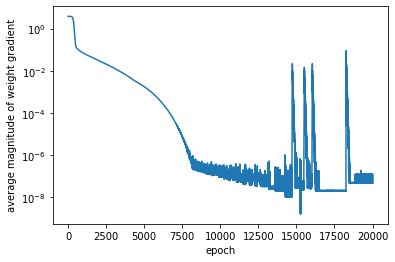

In [25]:
model_pytorch = LogisticRegressionPytorch()
model_pytorch.train()

#optimizer = torch.optim.SGD(model_pytorch.parameters(), lr=0.02)
optimizer = torch.optim.Adam(model_pytorch.parameters())
criterion = torch.nn.BCELoss()
grad_magnitudes = []

X_data = Variable(torch.Tensor(np.array(experiment_1_data)))
y_data = Variable(torch.Tensor(np.array(experiment_1_outputs))).reshape([714, 1])
for epoch in range(20000):
    optimizer.zero_grad()
    # Forward pass
    y_pred = model_pytorch(X_data)
    # Compute Loss
    loss = criterion(y_pred, y_data)
    # Backward pass
    loss.backward()
    for name, param in model_pytorch.named_parameters():
        if name == 'linear.weight':
            grad_magnitudes.append(np.abs(param.grad.numpy()).mean())

    if epoch % 10000 == 0:
        print("epoch", epoch)
        for name, param in model_pytorch.named_parameters():
            print(name, "value", param.data, "gradient", param.grad)
    optimizer.step()

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(grad_magnitudes)
plt.xlabel('epoch')
plt.ylabel('average magnitude of weight gradient')
plt.yscale('log')
plt.show()

*Code breakdown*

Put the model into training mode (this only affects certain models that behave differently during training and testing).  Even though it doesn't affect our logistic regression model, calling the `.train` function is a good habit to get into.

```python
model_pytorch.train()
```

Create an optimizer that will tune the parameters of the network.  Here we are using an algorithm called *stochastic gradient descent*.  It's a very popular choice for an optimizer.  Similarly to gradient descent it optimizes a function by stepping down the gradient (step size is given by learning rate or `lr`).  Where it differs from normal gradient descent is that it doesn't necessarily use all of the data to compute the gradient.  If you have a big dataset, it might only use a small number of data points, compute gradient over those, and then step down that estimate of the gradient.  The collection of datapoints used for estimating the gradient is called a *mini batch*.  In this example we are using the entire dataset each time, so we are really doing normal gradient descent.

```python
optimizer = torch.optim.SGD(model_pytorch.parameters(), lr=0.01)
```

The criterion defines the loss function we are minimizing.  When the training outputs are binary, the `BCELoss` function is equivalent to the log loss that we have been using in this course.

```python
criterion = torch.nn.BCELoss()
```

In order to operate on data in pytorch, you have to convert any matrix or vector data into a pytorch variable.  This should be familiar based on the tutorial you went through earlier.

```python
X_data = Variable(torch.Tensor(np.array(experiment_1_data)))
y_data = Variable(torch.Tensor(np.array(experiment_1_outputs)))
```

An *epoch* in neural network training is a single pass through the data.  In this case we are taking a single gradient step on the whole dataset, so the number of epochs is the same as the number of gradient steps.
```python
for epoch in range(200):
```

This tells the optimizer to throw away any gradients it has accumulated from previous data (do not forget to call this!!!).

```python
optimizer.zero_grad()
```

Apply the forward model to get predictions.

```python
y_pred = model_pytorch(X_data)
```

Calculate the loss of the model by comparing its predictions with the actual outputs.

```python
loss = criterion(y_pred, y_data)
```

Use backpropagation to compute the gradient of all of the model parameters with respect to the loss.

```python
loss.backward()
```

Calculate the gradient magnitudes so we can make a plot after training.
```python
for name, param in model_pytorch.named_parameters():
    if name == 'linear.weight':
        grad_magnitudes.append(np.abs(param.grad.numpy()).mean())
```

Print out the values of the parameters and the gradient of the parameters with respect to the loss every 50 epochs.

```python
if epoch % 50 == 0:
    print("epoch", epoch)
    for name, param in model_pytorch.named_parameters():
        print(name, "value", param.data, "gradient", param.grad)
```

Perform the gradient step.
```python
optimizer.step()
```

### Notebook Exercise 2 (30 minutes)

(a) Explain the output you see when you run the previous code cell.  How are the weights changing over time?  How is the gradient changing over time?  Is the algorithm close to converging (i.e., computing the optimal solution)?  How would you know if it has converged?

(b) Increase the number of epochs until you get convergence (you may want to make it so the gradient prints out less by changing the line `if epoch % 100 == 0` to `if epoch % 1000 == 0`).  Roughly how many did it take?

(c) Tune the learning rate to some other values.  How does this change the algorithm's behavior?

(d) Change the optimizer to the ADAM optimizer by swapping out the previous optimizer with this new line of code.

```python
optimizer = torch.optim.Adam(model_pytorch.parameters())
```

Roughly many epochs does it take to reach convergence now?


#### *Expand for Solution*

***Solution***

(a) (this might vary based on the random initialization of the weights in the network).  In this run the weights slowly adjusted to the values computed by the sklearn model.  The size of the gradient remained largely constant over time (as seen both in the output and in the plot).  This indicates that the algorithm has not converged yet.  If the gradient magnitude was close to 0, that would indicate convergence.

(b) It took about 150,000 epochs to reach convergence!

(c) Setting it too high causes divergence of the algorithm.  Setting it too low causes slow convergence.

(d) It seems to takea bout 10,000 epochs to converge (that's a huge speedup!)

## Multilayer Perceptron

Now that we've shown you how to implement the logistic regression model, we want you to implement the MLP model from the previous companion notebook.  Remember, the MLP had 2 input features (we didn't use `is young male` as an input) and 2 hidden units.  We'll provide you with the skeleton of the code as well as some code to generate the visualization from the previous notebook.

In [30]:
# start from this and modify it
class TitanicMLP(nn.Module):
    def __init__(self):
        super(TitanicMLP, self).__init__()
        self.input_layer = nn.Linear(2,2)
        self.hidden_layer = nn.Linear(2,1)

    def forward(self, X):
        """ Propagate data through the network.

            This model first applies the linear layer and then a sigmoid
        """
        S2 = self.input_layer(X)
        X2 = torch.sigmoid(S2)
        S3 = self.hidden_layer(X2)
        return torch.sigmoid(S3)

### Notebook Exercise 3 (20 minutes + 20 minutes of optional work)

Non-optional: modify the starter code listed above (where it says `class LogisticRegressionPytorch`) to create be a class called TitanicMLP that has 2 input units and 2 hidden units.  Train your network on the Titanic dataset (we recommend using the Adam optimizer you learned about in the last problem).  We have defined a function called `visualize_model_probs` for visualizing the probability plot that we saw in the last companion notebook (this code should be run after the model is done training).

*Optional:* visualize the hidden unit representations in the network (similar to what we did in the companion notebook last time).  Hint: you can define additional functions (rather than just `forward` to compute the hidden units in the network).

In [28]:
def visualize_model_probs(model):
    xx, yy = np.mgrid[-.1:1.1:.01, 0:85:.1]
    grid = np.c_[xx.ravel(), yy.ravel()]
    probs = model(Variable(torch.Tensor(grid))).detach().numpy().reshape(xx.shape)

    f, ax = plt.subplots(figsize=(8, 6))
    contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                        vmin=0, vmax=1)
    ax_c = f.colorbar(contour)
    ax_c.set_label("$P(survived)$")
    ax_c.set_ticks([0, .25, .5, .75, 1])

    ax.scatter(experiment_1_data['male'], experiment_1_data['Age'], c=experiment_1_outputs, s=50,
            cmap="RdBu", vmin=-.2, vmax=1.2,
            edgecolor="white", linewidth=1)

    ax.set(xlim=(-.1, 1.1),
        ylim=(0, 85),
        xlabel="is male", ylabel="age (years)")
    plt.show()

#### *Expand for Solution*

In [31]:
class TitanicMLP(nn.Module):
    def __init__(self):
        super(TitanicMLP, self).__init__()
        self.linear_1 = nn.Linear(2,2)
        self.linear_2 = nn.Linear(2,1)

    def forward(self, X):
        """ Propagate data through the network.

            This model first applies the linear layer, a sigmoid, a linear
            layer, and finally a sigmoid
        """
        X = self.linear_1(X)
        X = torch.sigmoid(X)
        X = self.linear_2(X)
        return torch.sigmoid(X)
    # Note: the hidden function is only needed if you want to visualize hidden
    # layers.  If you didn't do that part, you wouldn't have this in your
    # solution.
    def hidden(self, X):
        """ Propagate data to the hidden layer """
        X = self.linear_1(X)
        return torch.sigmoid(X)

epoch 0
linear_1.weight value tensor([[ 0.2632, -0.2813],
        [-0.4038,  0.2222]]) gradient tensor([[0.0001, 0.0019],
        [0.0005, 0.0092]])
linear_1.bias value tensor([-0.0525,  0.2563]) gradient tensor([6.9436e-05, 4.3943e-04])
linear_2.weight value tensor([[0.1386, 0.2573]]) gradient tensor([[5.8158e-05, 2.4386e-01]])
linear_2.bias value tensor([0.3724]) gradient tensor([0.2453])
epoch 1000
linear_1.weight value tensor([[-0.1465, -0.3590],
        [-1.0359, -0.0158]]) gradient tensor([[ 2.8755e-04, -2.3894e-05],
        [ 3.3460e-03, -1.2163e-02]])
linear_1.bias value tensor([1.3057, 0.0528]) gradient tensor([-0.0008, -0.0003])
linear_2.weight value tensor([[1.3056, 0.1449]]) gradient tensor([[-0.0019, -0.0133]])
linear_2.bias value tensor([-0.2832]) gradient tensor([0.0465])
epoch 2000
linear_1.weight value tensor([[-2.3896, -0.0058],
        [-2.4774,  0.0129]]) gradient tensor([[ 0.0199,  0.0002],
        [ 0.0036, -0.0001]])
linear_1.bias value tensor([ 0.4291, -0.2266])

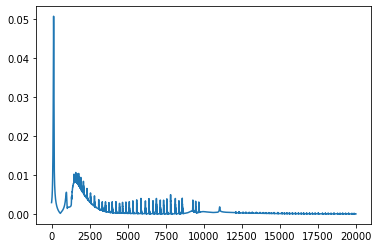

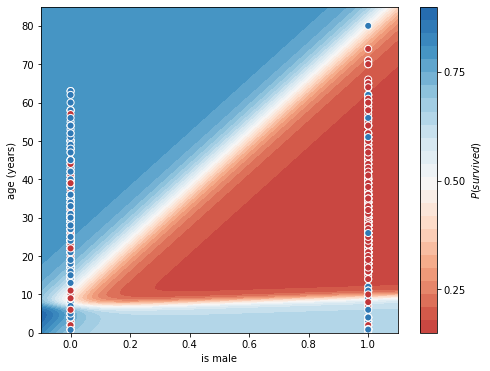

In [32]:
mlp_pytorch = TitanicMLP()
mlp_pytorch.train()
optimizer = torch.optim.Adam(mlp_pytorch.parameters())
criterion = torch.nn.BCELoss()
grad_magnitudes = []

X_data = Variable(torch.Tensor(np.array(experiment_1_data.drop('is_young_male',axis=1))))
y_data = Variable(torch.Tensor(np.array(experiment_1_outputs))).reshape([714, 1])
for epoch in range(20000):
    optimizer.zero_grad()
    # Forward pass
    y_pred = mlp_pytorch(X_data)
    # Compute Loss
    loss = criterion(y_pred, y_data)
    # Backward pass
    loss.backward()
    for name, param in mlp_pytorch.named_parameters():
        if name == 'linear_1.weight':
            grad_magnitudes.append(np.abs(param.grad.numpy()).mean())

    if epoch % 1000 == 0:
        print("epoch", epoch)
        for name, param in mlp_pytorch.named_parameters():
            print(name, "value", param.data, "gradient", param.grad)
    optimizer.step()

plt.plot(grad_magnitudes)
plt.show()
visualize_model_probs(mlp_pytorch)

The next code block visualizes the hidden layer activations.

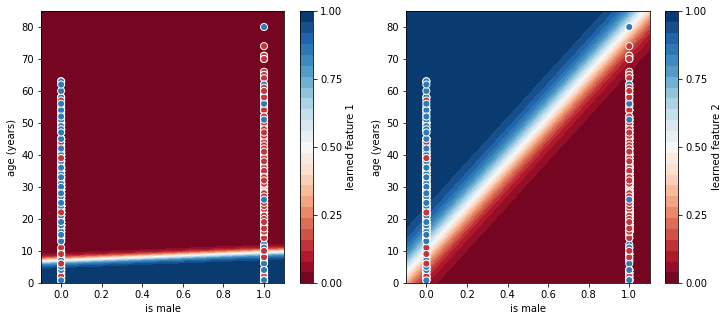

In [33]:
f = plt.figure(figsize=(12, 5))
xx, yy = np.mgrid[-.1:1.1:.01, 0:85:.1]
grid = np.c_[xx.ravel(), yy.ravel()]
hidden_units = mlp_pytorch.hidden(Variable(torch.Tensor(grid))).detach().numpy()
for i in range(2):
    ax = f.add_subplot(1,2,i+1)
    contour = ax.contourf(xx, yy, hidden_units[:,i].reshape(xx.shape), 25, cmap="RdBu",
                        vmin=0, vmax=1)

    ax.scatter(experiment_1_data['male'], experiment_1_data['Age'], c=experiment_1_outputs, s=50,
            cmap="RdBu", vmin=-.2, vmax=1.2,
            edgecolor="white", linewidth=1)
    ax_c = f.colorbar(contour)
    ax_c.set_label("learned feature %d" %(i+1))
    ax_c.set_ticks([0, .25, .5, .75, 1])

    ax.set(xlim=(-.1, 1.1),
        ylim=(0, 85),
        xlabel="is male", ylabel="age (years)")
plt.show()